In [1]:
import pandas as pd
from mpl_toolkits.basemap import Basemap
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from pandas import Timestamp
from datetime import datetime
import os

In [2]:
# import data
training_data = pd.read_pickle("../training-data/20M_normalized_samples.pkl")
test_data = pd.read_pickle("../training-data/normalized_test_data_may_2017.pkl")

feature_to_predict = 'co2flux' #,'fco2','co2flux_pre','fco2_pre'
input_features = ['SST','SAL','ice_frac','mixed_layer_depth','heat_flux_down','water_flux_up','stress_X','stress_Y','currents_X','currents_Y','nav_lat','nav_lon','month','year','global_co2']

X = training_data[input_features]
Y = training_data[feature_to_predict]

In [ ]:
model = tf.keras.models.Sequential([
     tf.keras.layers.Dense(128, input_dim=15, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)),
     tf.keras.layers.BatchNormalization(),
    # Dropout(0.2),
    
     tf.keras.layers.Dense(256, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)),
     tf.keras.layers.BatchNormalization(),
     tf.keras.layers.Dropout(0.2),
    
     tf.keras.layers.Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)),
     tf.keras.layers.BatchNormalization(),
     tf.keras.layers.Dropout(0.2),

    # for co2flux
     tf.keras.layers.Dense(1, activation='linear',kernel_initializer='zeros')
])

lr = 0.0001
loss_function= 'mse'

# Compile the model
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
    loss=loss_function,
    metrics=['mae']
)

/Users/jakobmeggendorfer/Documents/CAU/Masterarbeit/master-thesis/env/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [5]:
# Set number of epochs, batch size and learning rate:
n_epochs = 20
batch_size = 1024

# Callbacks for better training
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=4, restore_best_weights=True)
lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, min_lr=1e-6)

# Train the model
history = model.fit(
    X, 
    Y, 
    epochs=n_epochs,             
    batch_size=batch_size,      
    validation_split=0.2, 
    callbacks=[early_stopping, lr_scheduler]
)

Epoch 1/20
15625/15625 ━━━━━━━━━━━━━━━━━━━━ 158s 10ms/step - loss: 0.3709 - mae: 0.3573 - val_loss: 0.3039 - val_mae: 0.3109 - learning_rate: 1.0000e-04
Epoch 2/20
15625/15625 ━━━━━━━━━━━━━━━━━━━━ 157s 10ms/step - loss: 0.3344 - mae: 0.3421 - val_loss: 0.3024 - val_mae: 0.3153 - learning_rate: 1.0000e-04
Epoch 3/20
15625/15625 ━━━━━━━━━━━━━━━━━━━━ 160s 10ms/step - loss: 0.3129 - mae: 0.3338 - val_loss: 0.2472 - val_mae: 0.2796 - learning_rate: 1.0000e-04
Epoch 4/20
15625/15625 ━━━━━━━━━━━━━━━━━━━━ 160s 10ms/step - loss: 0.2969 - mae: 0.3274 - val_loss: 0.2657 - val_mae: 0.2967 - learning_rate: 1.0000e-04
Epoch 5/20
15625/15625 ━━━━━━━━━━━━━━━━━━━━ 157s 10ms/step - loss: 0.2856 - mae: 0.3229 - val_loss: 0.2391 - val_mae: 0.2788 - learning_rate: 1.0000e-04
Epoch 6/20
15625/15625 ━━━━━━━━━━━━━━━━━━━━ 156s 10ms/step - loss: 0.2760 - mae: 0.3193 - val_loss: 0.2211 - val_mae: 0.2713 - learning_rate: 1.0000e-04
Epoch 7/20
15625/15625 ━━━━━━━━━━━━━━━━━━━━ 145s 9ms/step - loss: 0.2680 - mae: 0.

In [6]:
X_test = test_data[input_features]

# run model on test data
test_pred = model.predict(X_test)
# add prediction to data frame for displaying data
pred_reshaped = np.array(test_pred).reshape(-1)
test_results = test_data.assign(prediction=pd.Series(pred_reshaped).values)

28256/28256 ━━━━━━━━━━━━━━━━━━━━ 10s 356us/step


In [7]:
mse = mean_squared_error(test_results[feature_to_predict], test_results['prediction'])
mae = mean_absolute_error(test_results[feature_to_predict], test_results['prediction'])
print(f"Mean Squared Error: {mse:.2f}")
print(f"Mean Absolute Error: {mae:.2f}")

Mean Squared Error: 0.15
Mean Absolute Error: 0.26


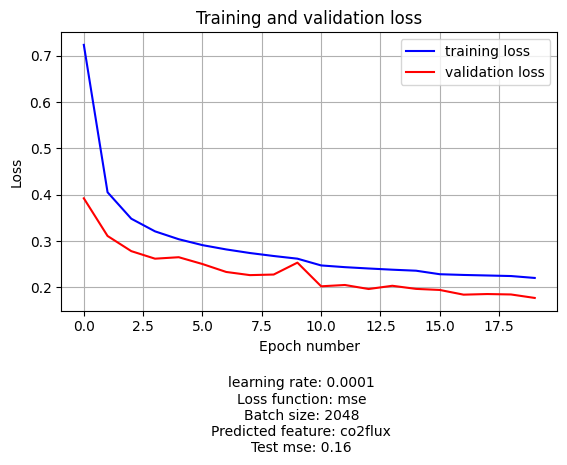

In [ ]:
plt.plot(history.history['loss'], color = 'blue', label = 'training loss')
plt.plot(history.history['val_loss'], color = 'red', label = 'validation loss')
plt.xlabel('Epoch number')
plt.ylabel('Loss')
plt.title('Training and validation loss')
plt.grid(True)
plt.legend()

plt.subplots_adjust(bottom=0.3)
plt.figtext(0.5, 0.01, f"learning rate: {lr}\nLoss function: {loss_function}\nBatch size: {str(batch_size)}\nPredicted feature: {feature_to_predict}\nTest mse: {mse:.2f}\nTest mae: {mae:.2f}",
            wrap=True, horizontalalignment='center', fontsize=10, color='black')

timestamp = datetime.now().strftime('%Y-%m-%d_%H-%M')
path = '../plots/perceptron/' + timestamp + '_training_validation_loss.png'
plt.savefig(path, format='png', dpi=300)
plt.show()  

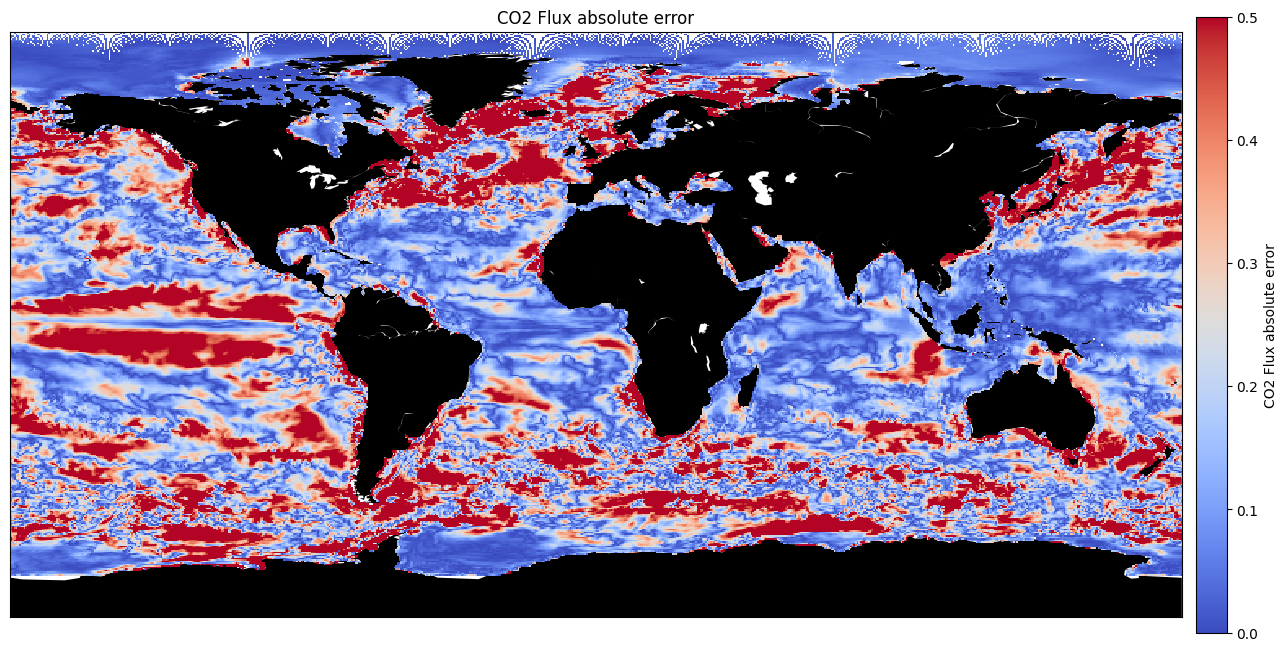

In [13]:
dataframe = test_results

# Define map boundaries
lat_min, lat_max = -77, 90
lon_min, lon_max = -180, 180

# Create a grid
num_lat, num_lon = 360, 720  # Grid resolution
lat_grid = np.linspace(lat_min, lat_max, num_lat)
lon_grid = np.linspace(lon_min, lon_max, num_lon)
lon_grid, lat_grid = np.meshgrid(lon_grid, lat_grid)

m = Basemap(projection='cyl',
            llcrnrlat=-90, urcrnrlat=90,
            llcrnrlon=-180, urcrnrlon=180,
            resolution='c')

# Initialize grid with zeros
grid_values = np.zeros_like(lat_grid)

# Map DataFrame values to the grid
# Find the closest grid point for each latitude/longitude in the DataFrame
for _, row in dataframe.iterrows():
    lat_idx = np.argmin(np.abs(lat_grid[:, 0] - row['nav_lat_not_scaled']))
    lon_idx = np.argmin(np.abs(lon_grid[0, :] - row['nav_lon_not_scaled']))
    grid_values[lat_idx, lon_idx] = abs(row[feature_to_predict]-row['prediction'])

plt.figure(figsize=(18, 8))
m.fillcontinents(color='black')

# Mask the data over land
masked_data = np.ma.masked_where(grid_values == 0, grid_values)

x, y = m(lon_grid, lat_grid)
pcm = m.pcolormesh( x, y, masked_data,  vmin='0', vmax='0.5', cmap='coolwarm', shading='auto', latlon=True)
cbar = plt.colorbar(pcm, orientation='vertical', pad=0.01)
cbar.set_label('CO2 Flux absolute error')

plt.title(f"CO2 Flux absolute error")
plt.show()

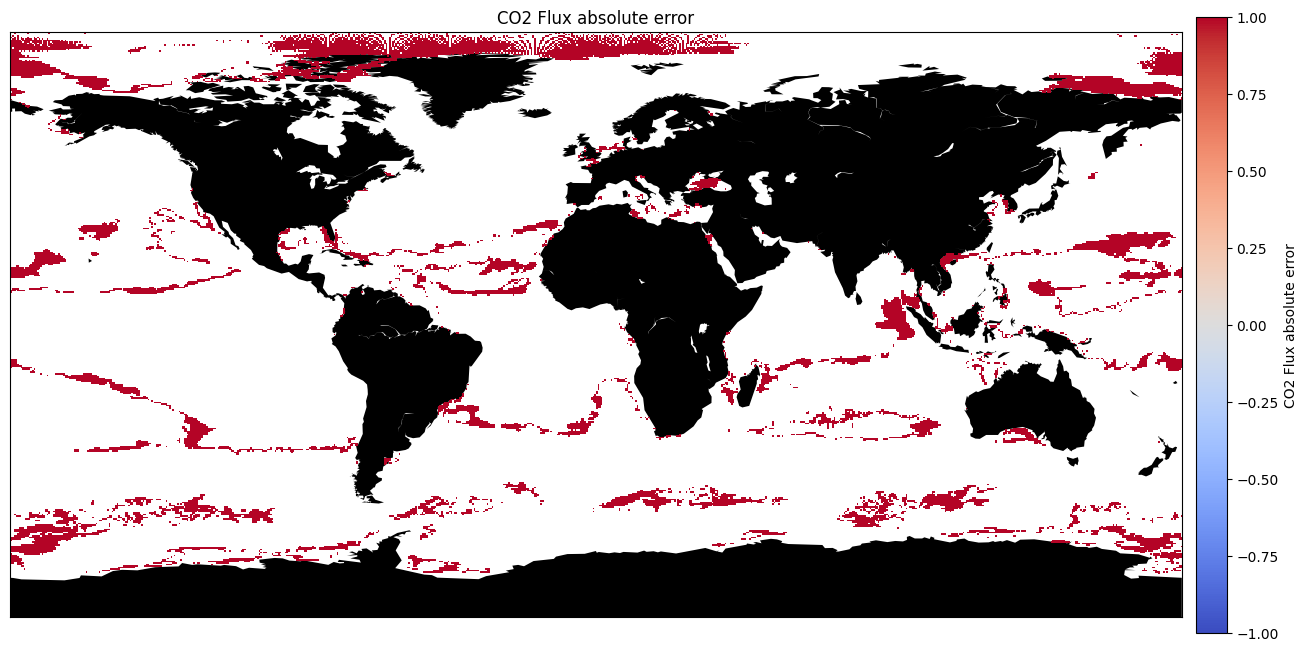

In [11]:
dataframe = test_results

# Define map boundaries
lat_min, lat_max = -77, 90
lon_min, lon_max = -180, 180

# Create a grid
num_lat, num_lon = 360, 720  # Grid resolution
lat_grid = np.linspace(lat_min, lat_max, num_lat)
lon_grid = np.linspace(lon_min, lon_max, num_lon)
lon_grid, lat_grid = np.meshgrid(lon_grid, lat_grid)

m = Basemap(projection='cyl',
            llcrnrlat=-90, urcrnrlat=90,
            llcrnrlon=-180, urcrnrlon=180,
            resolution='c')

# Initialize grid with zeros
grid_values = np.zeros_like(lat_grid)

# Map DataFrame values to the grid
# Find the closest grid point for each latitude/longitude in the DataFrame
for _, row in dataframe.iterrows():
    lat_idx = np.argmin(np.abs(lat_grid[:, 0] - row['nav_lat_not_scaled']))
    lon_idx = np.argmin(np.abs(lon_grid[0, :] - row['nav_lon_not_scaled']))
    grid_values[lat_idx, lon_idx] = abs(abs(row['prediction'])/row['prediction']-abs(row[feature_to_predict])/row[feature_to_predict])

plt.figure(figsize=(18, 8))
m.fillcontinents(color='black')

# Mask the data over land
masked_data = np.ma.masked_where(grid_values == 0, grid_values)

x, y = m(lon_grid, lat_grid)
pcm = m.pcolormesh( x, y, masked_data,  vmin='-1', vmax='1', cmap='coolwarm', shading='auto', latlon=True)
cbar = plt.colorbar(pcm, orientation='vertical', pad=0.01)
cbar.set_label('CO2 Flux absolute error')

plt.title(f"CO2 Flux absolute error")
plt.show()

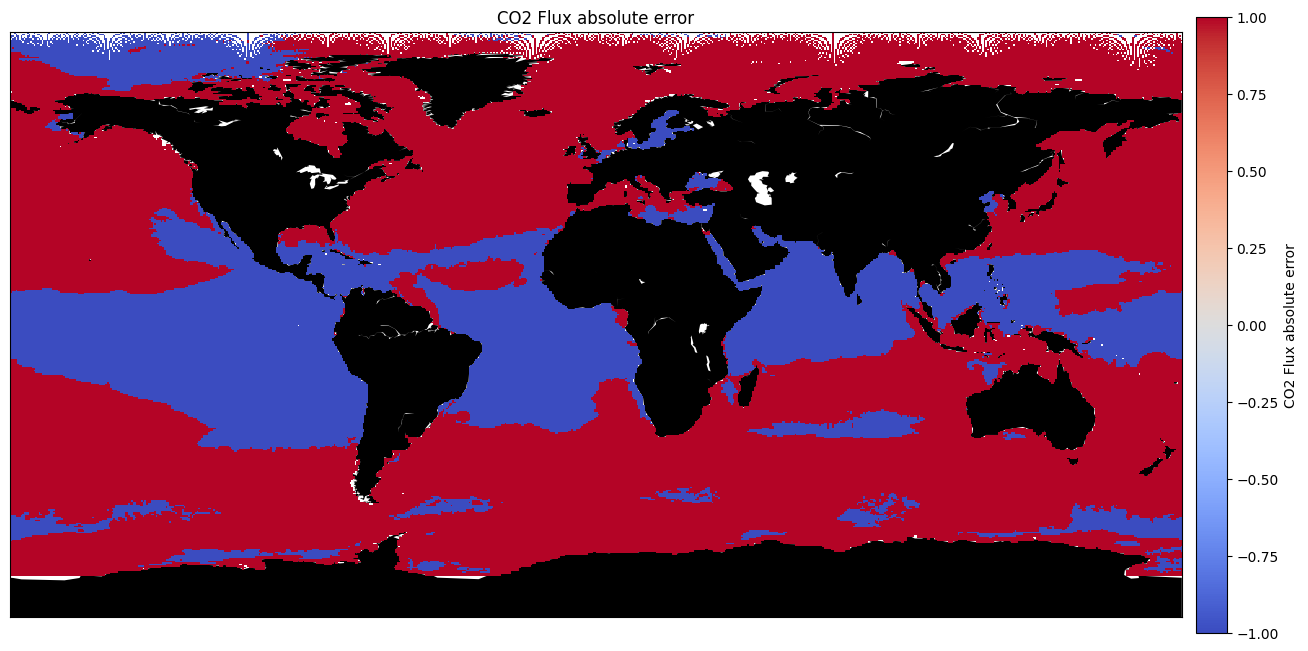

In [ ]:
dataframe = test_results

# Define map boundaries
lat_min, lat_max = -77, 90
lon_min, lon_max = -180, 180

# Create a grid
num_lat, num_lon = 360, 720  # Grid resolution
lat_grid = np.linspace(lat_min, lat_max, num_lat)
lon_grid = np.linspace(lon_min, lon_max, num_lon)
lon_grid, lat_grid = np.meshgrid(lon_grid, lat_grid)

m = Basemap(projection='cyl',
            llcrnrlat=-90, urcrnrlat=90,
            llcrnrlon=-180, urcrnrlon=180,
            resolution='c')

# Initialize grid with zeros
grid_values = np.zeros_like(lat_grid)

# Map DataFrame values to the grid
# Find the closest grid point for each latitude/longitude in the DataFrame
for _, row in dataframe.iterrows():
    lat_idx = np.argmin(np.abs(lat_grid[:, 0] - row['nav_lat_not_scaled']))
    lon_idx = np.argmin(np.abs(lon_grid[0, :] - row['nav_lon_not_scaled']))
    grid_values[lat_idx, lon_idx] = abs(row['prediction'])/row['prediction']

plt.figure(figsize=(18, 8))
m.fillcontinents(color='black')

# Mask the data over land
masked_data = np.ma.masked_where(grid_values == 0, grid_values)

x, y = m(lon_grid, lat_grid)
pcm = m.pcolormesh( x, y, masked_data,  vmin='-1', vmax='1', cmap='coolwarm', shading='auto', latlon=True)
cbar = plt.colorbar(pcm, orientation='vertical', pad=0.01)
cbar.set_label('CO2 Flux absorbing/desorbing prediction')

plt.title(f"CO2 Flux absorbing/desorbing prediction")
plt.show()

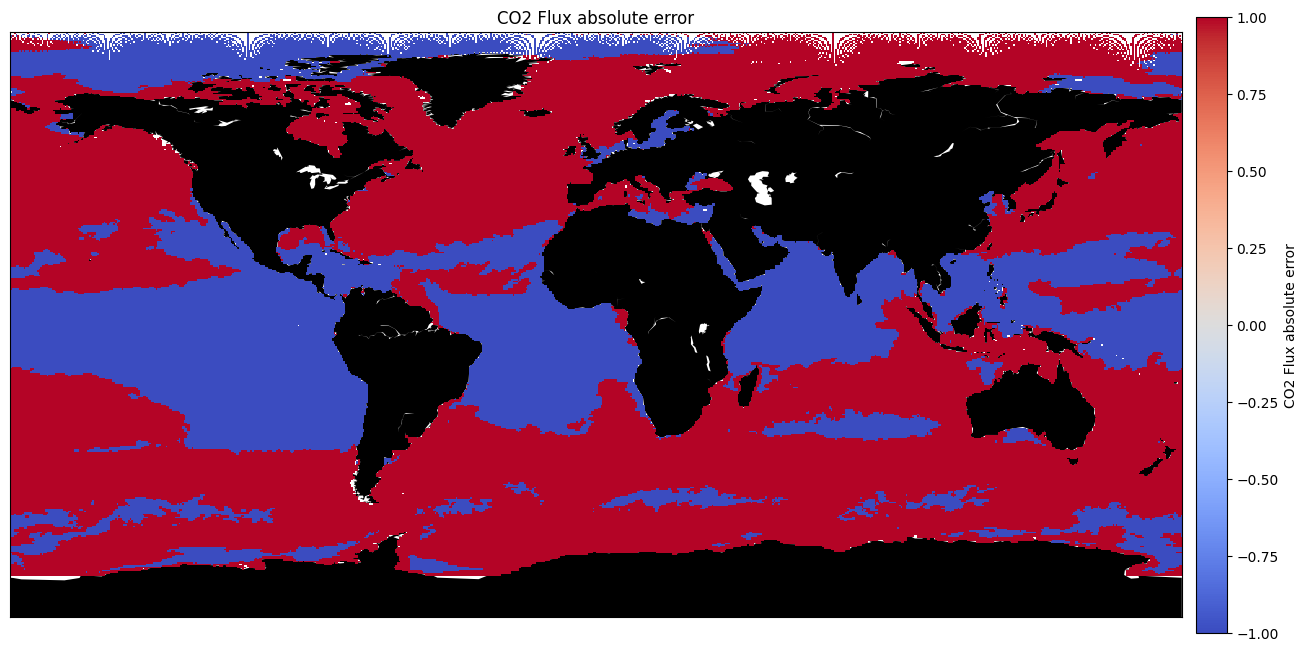

In [ ]:
dataframe = test_results

# Define map boundaries
lat_min, lat_max = -77, 90
lon_min, lon_max = -180, 180

# Create a grid
num_lat, num_lon = 360, 720  # Grid resolution
lat_grid = np.linspace(lat_min, lat_max, num_lat)
lon_grid = np.linspace(lon_min, lon_max, num_lon)
lon_grid, lat_grid = np.meshgrid(lon_grid, lat_grid)

m = Basemap(projection='cyl',
            llcrnrlat=-90, urcrnrlat=90,
            llcrnrlon=-180, urcrnrlon=180,
            resolution='c')

# Initialize grid with zeros
grid_values = np.zeros_like(lat_grid)

# Map DataFrame values to the grid
# Find the closest grid point for each latitude/longitude in the DataFrame
for _, row in dataframe.iterrows():
    lat_idx = np.argmin(np.abs(lat_grid[:, 0] - row['nav_lat_not_scaled']))
    lon_idx = np.argmin(np.abs(lon_grid[0, :] - row['nav_lon_not_scaled']))
    grid_values[lat_idx, lon_idx] = abs(row[feature_to_predict])/row[feature_to_predict]

plt.figure(figsize=(18, 8))
m.fillcontinents(color='black')

# Mask the data over land
masked_data = np.ma.masked_where(grid_values == 0, grid_values)

x, y = m(lon_grid, lat_grid)
pcm = m.pcolormesh( x, y, masked_data,  vmin='-1', vmax='1', cmap='coolwarm', shading='auto', latlon=True)
cbar = plt.colorbar(pcm, orientation='vertical', pad=0.01)
cbar.set_label('CO2 Flux absorbing/desorbing truth')

plt.title(f"CO2 Flux absorbing/desorbing truth")
plt.show()